In [1]:
import pandas as pd
import numpy as np
import datetime
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import re
from nltk import ngrams
from nltk.probability import FreqDist
from langdetect import detect
import matplotlib.pyplot as plt; plt.rcdefaults()
from gensim.models import word2vec
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import Imputer

In [2]:
#jupyter notebook setting: to show the full texts in the output window
pd.set_option('display.max_colwidth', -1)

In [3]:
#input file:  tweet dataset
rawTweetData=pd.read_csv('/Users/Mandy/Study/SpringBoard/Capstone 2/GoldTweetDataWorkBook.csv',encoding='latin1')
print(rawTweetData.head())


       date  score  language  \
0  12/31/17 -1     NaN         
1  12/31/17  0     NaN         
2  12/31/17  1     NaN         
3  12/31/17  0     NaN         
4  12/31/17  0     NaN         

                                                                                                                                                       text  
0  Steve Harrigan reports on @POTUS ' #NewYearsEve - from the U.S. economy to tonight's party at Mar-a-Lago. #FoxNews2018 pic.twitter.com/wb75BhZ37F         
1  Iran's protests are partly a reaction to a sputtering economy . But there's something bigger at play. http:// cnn.it/2En0qtL pic.twitter.com/lIKazEzNRf   
2  Just a reminder Britney Spears singlehandedly saved the economy by releasing Work Bitch.                                                                  
3  No                                                                                                                                                        
4  Wondering what

In [4]:
#function to detect non-English tweets and delete those rows
def findLanguage(row):
    try:
        return detect(row)
    except:
        return "empty"

In [5]:
#preprocessing 1/4 : delete non-English rows
rawTweetData.language = rawTweetData.text.apply(findLanguage)
rawTweetData=rawTweetData[rawTweetData.language=='en']
rawTweetData=rawTweetData.loc[:,['date','score','language','text']]
print(rawTweetData.head())

       date  score language  \
0  12/31/17 -1      en        
1  12/31/17  0      en        
2  12/31/17  1      en        
4  12/31/17  0      en        
5  12/31/17 -1      en        

                                                                                                                                                                                                                                                             text  
0  Steve Harrigan reports on @POTUS ' #NewYearsEve - from the U.S. economy to tonight's party at Mar-a-Lago. #FoxNews2018 pic.twitter.com/wb75BhZ37F                                                                                                               
1  Iran's protests are partly a reaction to a sputtering economy . But there's something bigger at play. http:// cnn.it/2En0qtL pic.twitter.com/lIKazEzNRf                                                                                                         
2  Just a reminder Britney Spears

In [6]:
#preprocessing 2/4: replace special characters, such as URLs, usernames, hashtags, pictures
#also remove all the special characters
for row in rawTweetData.index:
    eachTweet=rawTweetData.text[row]
    eachTweet_url=re.sub(r"https:// \S+","URL",eachTweet)
    eachTweet_pic=re.sub(r"pic.\S+","PICTURE",eachTweet_url)
    eachTweet_user=re.sub(r"@\S+","USER",eachTweet_pic)
    eachTweet_hashtag=re.sub(r"#\S+","HASHTAG",eachTweet_user)
    eachTweet_spechar=re.sub("[^A-Za-z0-9]+"," ",eachTweet_hashtag).lower()
    rawTweetData.set_value(row,'Tweet',eachTweet_spechar)
print(rawTweetData.head())

       date  score language  \
0  12/31/17 -1      en        
1  12/31/17  0      en        
2  12/31/17  1      en        
4  12/31/17  0      en        
5  12/31/17 -1      en        

                                                                                                                                                                                                                                                             text  \
0  Steve Harrigan reports on @POTUS ' #NewYearsEve - from the U.S. economy to tonight's party at Mar-a-Lago. #FoxNews2018 pic.twitter.com/wb75BhZ37F                                                                                                                
1  Iran's protests are partly a reaction to a sputtering economy . But there's something bigger at play. http:// cnn.it/2En0qtL pic.twitter.com/lIKazEzNRf                                                                                                          
2  Just a reminder Britney Spe

In [7]:
#preprocessing 3/4: Split tweet text word by word (tokenize)
tokenizedTweet = rawTweetData.apply(lambda row: word_tokenize(row['Tweet']), axis=1)
print(tokenizedTweet.head())

0    [steve, harrigan, reports, on, user, hashtag, from, the, u, s, economy, to, tonight, s, party, at, mar, a, lago, hashtag, picture]                                                                                                                                                        
1    [iran, s, protests, are, partly, a, reaction, to, a, sputtering, economy, but, there, s, something, bigger, at, play, http, cnn, it, 2en0qtl, picture]                                                                                                                                    
2    [just, a, reminder, britney, spears, singlehandedly, saved, the, economy, by, releasing, work, bitch]                                                                                                                                                                                     
4    [wondering, what, s, going, on, with, ecuador, s, economy, wonder, how, bitcoin, can, help, read, our, informative, article, on, ou

In [8]:
#preprocessing 4/4: remove stopwords( words that don't have any positive/negative meanings)
filteredTweet = tokenizedTweet.apply(lambda x: [word for word in x if word not in stopwords.words('english')])
print(filteredTweet.head())

0    [steve, harrigan, reports, user, hashtag, u, economy, tonight, party, mar, lago, hashtag, picture]                                                                                                             
1    [iran, protests, partly, reaction, sputtering, economy, something, bigger, play, http, cnn, 2en0qtl, picture]                                                                                                  
2    [reminder, britney, spears, singlehandedly, saved, economy, releasing, work, bitch]                                                                                                                            
4    [wondering, going, ecuador, economy, wonder, bitcoin, help, read, informative, article, blog, http, ow, ly, 53lb30hvquu]                                                                                       
5    [still, wait, see, streets, however, least, three, different, camps, recent, days, gov, economy, corruption, green, camp, 2009, election, prote

In [9]:
#Tweet data after all the pre-processing steps
tweetData=rawTweetData.loc[:,['date','score']]
tweetData=pd.concat([tweetData, filteredTweet], axis=1)
tweetData.columns=['date','score','tweet']
print(tweetData.head())

       date  score  \
0  12/31/17 -1       
1  12/31/17  0       
2  12/31/17  1       
4  12/31/17  0       
5  12/31/17 -1       

                                                                                                                                                                                                             tweet  
0  [steve, harrigan, reports, user, hashtag, u, economy, tonight, party, mar, lago, hashtag, picture]                                                                                                               
1  [iran, protests, partly, reaction, sputtering, economy, something, bigger, play, http, cnn, 2en0qtl, picture]                                                                                                    
2  [reminder, britney, spears, singlehandedly, saved, economy, releasing, work, bitch]                                                                                                                              
4  [wondering, 

In [10]:
#function to combine every words from all the tweets into a word library
def get_words_in_tweets(tweets):
    all_words = []
    for words in tweets:
        all_words.extend(words)
    return all_words

#call the function
word_list=get_words_in_tweets(filteredTweet)

In [11]:
# a distribution table of words and their corresponding frequencies
word_features=FreqDist(word for word in word_list)
word_freq=[word_features[w] for w in word_features]
target_word=list(word_features.keys())
word_freq=pd.DataFrame(word_freq)
target_word=pd.DataFrame(target_word)
word_freq_dist=pd.concat([target_word,word_freq],axis=1)
word_freq_dist.columns=['target_word','frequency']
word_freq_dist=word_freq_dist.sort_values('frequency',ascending=False)
print(word_freq_dist.head())

    target_word  frequency
6    economy     10415    
4    hashtag     8417     
3    user        5523     
195  economic    5109     
11   picture     3131     


In [12]:
#delete rows with the replacement words: URL, PICTURE, USER, HASHTAG
word_freq_dist = word_freq_dist[word_freq_dist.target_word != 'url']
word_freq_dist = word_freq_dist[word_freq_dist.target_word != 'http']
word_freq_dist = word_freq_dist[word_freq_dist.target_word != 'picture']
word_freq_dist = word_freq_dist[word_freq_dist.target_word != 'user']
word_freq_dist = word_freq_dist[word_freq_dist.target_word != 'hashtag']
print(word_freq_dist.head())

    target_word  frequency
6    economy     10415    
195  economic    5109     
83   trump       2547     
126  us          1352     
300  people      1151     


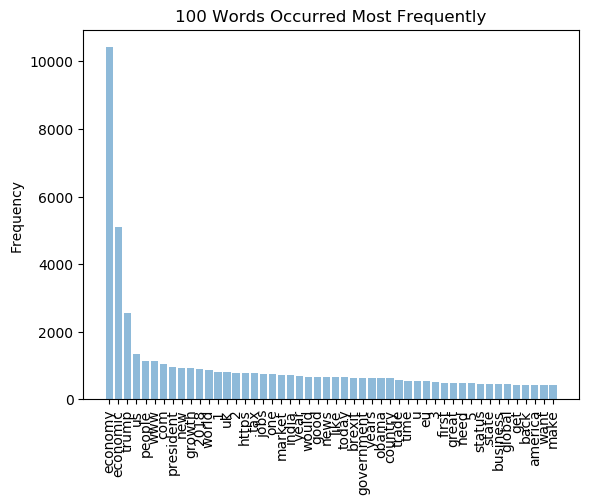

In [13]:
# draw a bar chart to show the frequency of the 100 most common words
x_word = word_freq_dist.iloc[0:50,0]
y_pos = np.arange(len(x_word))
y_freq = word_freq_dist.iloc[0:50,1]

plt.bar(y_pos, y_freq, align='center', alpha=0.5)
plt.xticks(y_pos, x_word)
plt.ylabel('Frequency')
plt.title('100 Words Occurred Most Frequently')
plt.xticks(rotation=90)
 
plt.show()

In [14]:
#split Tweet data into trainning set and text set 
#total tweet data is 20478, 60% will be used to train the model.
train_sentiment=tweetData.iloc[0:12285,:]
test_sentiment=tweetData.iloc[12285:,:]

In [15]:
# Creating the model and setting values for the various parameters
num_features = 300  # Word vector dimensionality
min_word_count = 40 # Minimum word count
num_workers = 5     # Number of parallel threads
context = 10       # Context window size
downsampling = 1e-3 # (0.001) Downsample setting for frequent words

# Initializing the train model
model = word2vec.Word2Vec(train_sentiment.tweet,\
                          workers=num_workers,\
                          size=num_features,\
                          min_count=min_word_count,\
                          window=context,
                          sample=downsampling)

# To make the model memory efficient
model.init_sims(replace=True)

# Saving the model for later use. Can be loaded using Word2Vec.load()
model_name = "300features_40minwords_10context"
model.save(model_name)

In [16]:
# This will give the total number of words in the vocabolary created from this dataset
model.wv.syn0.shape

/Users/Mandy/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: DeprecationWarning: Call to deprecated `syn0` (Attribute will be removed in 4.0.0, use self.wv.vectors instead).
  


(723, 300)

In [17]:
# This will print the most similar words present in the model
model.wv.most_similar("economic")

[('opportunities', 0.9895972609519958),
 ('opportunity', 0.9894675016403198),
 ('future', 0.9880902767181396),
 ('secretary', 0.9872471690177917),
 ('together', 0.9866265654563904),
 ('climate', 0.986266553401947),
 ('change', 0.9855443239212036),
 ('vision', 0.9855387806892395),
 ('political', 0.9854916334152222),
 ('freedom', 0.9852175116539001)]

In [18]:
# Function to average all word vectors in a paragraph
def featureVecMethod(words, model, num_features):
    # Pre-initialising empty numpy array for speed
    featureVec = np.zeros(num_features,dtype="float32")
    nwords = 0
    
    #Converting Index2Word which is a list to a set for better speed in the execution.
    index2word_set = set(model.wv.index2word)
    
    for word in  words:
        if word in index2word_set:
            nwords = nwords + 1
            featureVec = np.add(featureVec,model[word])
    
    # Dividing the result by number of words to get average
    featureVec = np.divide(featureVec, nwords)
    return featureVec

In [19]:
#Vectorize the training set
train_FeatureVecs = np.zeros((len(train_sentiment),num_features),dtype="float32")
counter=0
for tweet in train_sentiment.iterrows():
    train_FeatureVecs[counter,:] = featureVecMethod(tweet[1][2], model, num_features)
    counter=counter+1
#testing: print out the first 50 features of the first training tweet
print(train_FeatureVecs[0,0:50])
print(counter)

/Users/Mandy/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  del sys.path[0]
/Users/Mandy/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in true_divide
  app.launch_new_instance()


[ 0.00945817  0.08000964  0.09881575 -0.00353561  0.00796146 -0.09795941
 -0.00853431 -0.02616312 -0.03975807  0.0265001   0.02252642 -0.0222103
  0.00180237 -0.030005   -0.02482033  0.03580517  0.00781598  0.00067173
  0.09601879 -0.01045964  0.00692157  0.01392593 -0.00803152 -0.00188458
  0.04165957 -0.01004323  0.01239936  0.00241031  0.01213147 -0.05579005
  0.04038535  0.00646954  0.00060368  0.03158095 -0.01669513  0.04469122
 -0.06447771  0.04476986 -0.03072003 -0.08445393  0.01256927  0.00144161
  0.08049873 -0.02718591  0.01837436  0.10465257 -0.11394984 -0.00223909
 -0.00793484 -0.00205031]
12285


In [20]:
#Vectorize the test set
test_FeatureVecs=np.zeros((len(test_sentiment),num_features),dtype="float32")
counter_test=0
for each_test_tweet in test_sentiment.iterrows():
    test_FeatureVecs[counter_test,:] = featureVecMethod(each_test_tweet[1][2], model, num_features)
    counter_test=counter_test+1
#testing: print out the first 50 features of the first testing tweet
print(test_FeatureVecs[0,0:50])
print(counter_test)

/Users/Mandy/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  del sys.path[0]
/Users/Mandy/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in true_divide
  app.launch_new_instance()


[ 0.0230606   0.08498941  0.06699137  0.05724878  0.05400904 -0.09491497
 -0.00136524 -0.01396808 -0.02926741  0.06622666 -0.00486923 -0.02419093
 -0.06363616 -0.0852375  -0.05699753 -0.00028374 -0.03654128  0.00995393
  0.07886991  0.08998648  0.05793155  0.03556081 -0.02159929  0.01201964
  0.01772364 -0.00923698 -0.00088119 -0.00313985 -0.02130071 -0.03912456
  0.03010812  0.02848328 -0.01427313  0.02219216  0.0326675   0.00945791
 -0.05535947 -0.03896655 -0.05856211 -0.082432    0.00631316 -0.04164335
  0.07142559 -0.03192982  0.06476849  0.07388384 -0.13114525 -0.0072624
 -0.00754034 -0.00106385]
8202


In [21]:
#test if the vectorized feature sets with NaN values and turn them to zero
if np.any(np.isnan(train_FeatureVecs))==True:
    where_are_NaNs = np.isnan(train_FeatureVecs)
    train_FeatureVecs[where_are_NaNs] = 0
    print(np.any(np.isnan(train_FeatureVecs)))
else:
    print('No NaN values in train_FeatureVecs')
#for test_set
if np.any(np.isnan(test_FeatureVecs))==True:
    where_are_NaNs = np.isnan(test_FeatureVecs)
    test_FeatureVecs[where_are_NaNs] = 0
    print(np.any(np.isnan(test_FeatureVecs)))
else:
    print('No NaN values in test_FeatureVecs')

False
False


In [22]:
#test if the vectorized feature sets with infinite numbers and replace them with zeros
if np.all(np.isfinite(train_FeatureVecs))==False:
    where_are_infinites=np.isinf(train_FeatureVecs)
    train_FeatureVecs[where_are_infinites] = 0
    print(np.all(np.isfinite(train_FeatureVecs)))
else:
    print('No infinite values in train_FeatureVecs')
#for test_set
if np.all(np.isfinite(test_FeatureVecs))==False:
    where_are_infinites=np.isinf(test_FeatureVecs)
    test_FeatureVecs[where_are_infinites] = 0
    print(np.all(np.isfinite(test_FeatureVecs)))
else:
    print('No infinite values in test_FeatureVecs')

No infinite values in train_FeatureVecs
No infinite values in test_FeatureVecs


In [23]:
#train_FeatureVecs = Imputer().fit_transform(train_FeatureVecs)
#test_FeatureVecs = Imputer().fit_transform(test_FeatureVecs)

In [24]:
# Fitting a random forest classifier to the training data
RF_classifier = RandomForestClassifier(n_estimators = 300) 
RF_classifier = RF_classifier.fit(train_FeatureVecs, train_sentiment["score"])

In [25]:
# Predicting the sentiment values for test data
result = RF_classifier.predict(test_FeatureVecs)
output = pd.DataFrame(data={"date":test_sentiment["date"], "score":result})
output.to_csv( "/Users/Mandy/Desktop/output.csv", index=False, quoting=3 )
print(output.head())

         date  score
13096  3/1/18  0    
13098  3/1/18 -1    
13099  3/1/18  1    
13100  3/1/18 -1    
13101  3/1/18  0    


In [30]:
RF_accuracy=RF_classifier.score(test_FeatureVecs,test_sentiment['score'])
print(RF_accuracy)
print(RF_classifier.predict_proba(test_FeatureVecs))

<class 'numpy.ndarray'>
0.33162643257742014
[[0.17666667 0.57166667 0.25166667]
 [0.52713414 0.39280124 0.08006462]
 [0.24728291 0.30654762 0.44616947]
 ...
 [0.50272222 0.18444444 0.31283333]
 [0.30691534 0.23754762 0.45553704]
 [0.29333333 0.39444444 0.31222222]]


In [58]:
#function to calculate the expected sentiment score for each tweet(row)
def expected_score(featureVec):
    prob=RF_classifier.predict_proba(featureVec.reshape(1, -1))
    #turn the 2D array into 1D
    prob=prob[0,:]
    product=prob*RF_classifier.classes_
    expected_score=sum(product)
    return expected_score

In [98]:
###testing for one row
featureVec=test_FeatureVecs[3,:]
score_t=expected_score([featureVec])
print("here is the score")
print(score_t)


here is the score
-0.06777777777777777


In [106]:
#for each tweet's vectorized features, the model predict a score. Calculare the score mean
testing=pd.DataFrame(test_FeatureVecs)
score_class=RF_classifier.classes_
score_list=testing.apply(lambda eachFeatureRow:expected_score([eachFeatureRow]),axis=1)
print(score_list.head())

0    0.075000
1   -0.447070
2    0.198887
3   -0.067778
4    0.011296
dtype: float64


In [111]:
print("The Score Mean is %f" %(np.mean(score_list)))
print("The Score Median is %f" %(np.median(score_list)))

The Score Mean is 0.013177
The Score Median is 0.010171
